# CS 4501 Algorithmic Economics - Project 1

**Note:** For each of the question, please add some print or graph drawing commands to show your results in a clear way and also necessary analyses and demonstrations to help people who are not in your group understand your logics and results.


## Part 1
### Question 1
Using a Jupyter notebook import the csv file as pandas dataframe.

In [4]:
import pandas as pd
import numpy as np
import time as time
from tqdm import tqdm
from sklearn import linear_model as lm
import matplotlib.pyplot as plt
df = pd.read_csv('./scanner_data.csv', index_col=0) # Tell pandas to ignore index column
print(df)
# Note: data format is DD/MM/YYYY and starts at 2/1/2016
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

print(  "Number of Customer_ID",    len(pd.unique(df['Customer_ID']))  )
print(  "Number of SKU  ",    len(pd.unique(df['SKU']))  )
print(df)

              Date  Customer_ID  Transaction_ID SKU_Category    SKU  Quantity  \
1       02/01/2016         2547               1          X52  0EM7L       1.0   
2       02/01/2016          822               2          2ML  68BRQ       1.0   
3       02/01/2016         3686               3          0H2  CZUZX       1.0   
4       02/01/2016         3719               4          0H2  549KK       1.0   
5       02/01/2016         9200               5          0H2  K8EHH       1.0   
...            ...          ...             ...          ...    ...       ...   
131702  04/07/2016        20203           32900          IEV  FO112       3.0   
131703  04/07/2016        20203           32900          N8U  I36F2       1.0   
131704  04/07/2016        20203           32900          U5F  4X8P4       1.0   
131705  04/07/2016        20203           32900          0H2  ZVTO4       1.0   
131706  04/07/2016        20203           32900          Q4N  QM9BP       1.0   

        Sales_Amount  
1   

<AxesSubplot:ylabel='Frequency'>

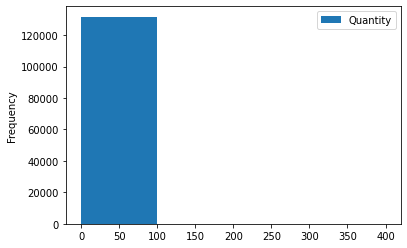

In [5]:
df.plot(x = "Sales_Amount", y = "Quantity", kind = "hist", stacked = True, bins=4)

### Question 2
The fact that consumer does not purchase anything can be 
interpreted as that she chose an outside option. Given that the fact that she chose an outside option is not recorded in this dataset, argue how you would construct a proxi variable for the choice of an outside option. Add such a proxi variable to your dataframe. 

**Hint:** you can use information that some consumers do not appear in the data every week. 

**Please input your answer in this cell:**




Add such a proxi variable to your dataframe. 


In [6]:
# Perform all necessary imports
import sys
from io import StringIO
from csv import writer
np.set_printoptions(threshold=1000) # Set display of numpy arrays to 1000 elements

df['chose_other'] = 0
df['week'] = 0
customers = df['Customer_ID'].unique() # Make a list of Customer_IDs
df2 = df # Copy dataframe
week = 0
grouped = df.groupby(pd.Grouper(key='Date', freq='W')) # Group the dataframe by week
print(len(df), 'transactions in original data')
for key, item in tqdm(grouped): 
    bought_this_week = item['Customer_ID'].unique() # make a list of unique items for each customer
    chose_other = set(customers) - set(bought_this_week) # Finds everyone who didn't buy this week
    date = item['Date'].iloc[0]
    num_other = len(chose_other) # Number of every individual who did not buy this week
    other_purchases = pd.DataFrame({'Date': [date for x in range(num_other)],
                                    'Customer_ID': [id for id in chose_other],
                                    'chose_other': [1 for x in range(num_other)],
                                    'SKU': ["0" for x in range(num_other)],
                                   'week': [week for x in range(num_other)]})
    
    df2 = pd.concat([df2, other_purchases.sample(frac=0.05)], ignore_index = True, axis=0) # Concatenate copied dataframe with other_purchases
    # print(df.iloc[-5:])
    week += 1 
 
## FILTER THE DATA
df2 = df2.sort_values(by='SKU') # Sort df2 by SKU
SKUIndices = {}
SKU = pd.unique(df2['SKU']) # Make a list of SKUs
for i in tqdm(range(0,len(SKU))):
    SKUIndices[SKU[i]] = i; # Assign an index to each SKU
    
customers = pd.unique(df['Customer_ID']) # Make a list of Customer_IDs
numCust = len(customers) # Number of  customers
numProd = len(SKU) # Number of SKUs

print(len(df2), 'transactions after adding outside choices')

131706 transactions in original data


100%|██████████████████████████████████| 5243/5243 [00:00<00:00, 1087519.70it/s]

188757 transactions after adding outside choices


### Question 3
Given that we do not have **explicit** consumer feature vectors $\mathbf{x}^i = (x^i_1, \cdots, x_k^i)$  in the data, discuss how you would construct such feature vectors for each consumer $i$ from the given data. Add your constructed characteristics to your dataframe. 

**Hint:** you can use transaction history and argue that past shopping patterns may give a good characterization for a given consumer.

**Please input your answer in this cell:**





Add your constructed characteristics to your dataframe. 

In [7]:
featureCount = 8 # We created 8 features + 1 more (Price) = 9 based on the data
custFeatureArr = np.zeros((numCust,featureCount))

for i in tqdm(range(numCust)):
    # First Organize Data & Calculate Features
    transactions = df[df.Customer_ID == customers[i]]
    custFeatureArr[i,0] = transactions.Quantity.sum() # Total quantity bought by consumer
    custFeatureArr[i,1] = transactions.Sales_Amount.sum() # Total $ spent by consumer
    custFeatureArr[i,2] = custFeatureArr[i,1]/len(transactions.Date.unique()) # Average price paid by consumer
    custFeatureArr[i,3] = len(transactions.Date.unique()) # Number of unique days on which consumer bought
    custFeatureArr[i,4] = len(transactions.SKU.unique()) # Number of SKUs bought by consumer
    custFeatureArr[i,5] = len(transactions.SKU_Category.unique()) # Number of different SKU categories bought by consumer
    custFeatureArr[i,6] = len(transactions.Date.dt.isocalendar().week.unique()) # Number of weeks consumer went to grocery store
    custFeatureArr[i,7] = 1 # Intercept term for multinomial logit regression

# Standardize the feature terms   
custFeatureArr[:,0:6] = (custFeatureArr[:,0:6] - np.mean(custFeatureArr[:,0:6],axis=0))/np.std(custFeatureArr[:,0:6],axis=0)

# Prices of products are the final 9th feature
prices = np.zeros((numProd,1))
prices[:,0] = df2.iloc[np.unique(df2.SKU.values,return_index=True)[1]].Sales_Amount / df2.iloc[np.unique(df2.SKU.values,return_index=True)[1]].Quantity
prices[0,0] = 0

# prices[:,:] = (prices[:,:] - np.mean(prices[:,:],axis=0))/np.std(prices[:,:],axis=0)
    

100%|████████████████████████████████████| 22625/22625 [00:50<00:00, 445.86it/s]


### Question 4
Produce the utility parameters $\beta_{0j}, \beta_{1j},\cdots \beta_{kj}$ and $\alpha_j$ for every product $j$  by estimating a multinomial 
logit model from your constructed dataset.

In [8]:
shuffledArr = np.concatenate((np.reshape(df2.Customer_ID.values,(len(df2),1)), np.reshape(df2.SKU.values,(len(df2),1))),axis=1)
np.random.shuffle(shuffledArr)

size = len(df2)
train = int(9*len(df2)/10) # Size of training set: 90% of data
test = len(df2) - train # Set of testing set: 10% of data

IDs = shuffledArr[0:size,0]
cats = shuffledArr[0:size,1]


X = np.zeros((size,featureCount + 1))
y = np.zeros(size)


for i in tqdm(range(size)): # Iterate through df2
    X[i,0:featureCount] = custFeatureArr[IDs[i] - 1] # Add in first 8 features to Inputs
    X[i,featureCount] = prices[SKUIndices[cats[i]]] # Add in prices as 9th feature to Inputs
    y[i] = SKUIndices[cats[i]] # Add in utilities to Outputs

100%|███████████████████████████████| 188757/188757 [00:00<00:00, 412233.24it/s]


In [9]:
lm.LogisticRegression(solver="lbfgs") 
lm.LogisticRegression(n_jobs=-1) 
lm.LogisticRegression(multi_class='multinomial')
    
tic = time.time()
model = lm.LogisticRegression().fit(X[0:train,:], y[0:train])
print(time.time() - tic)

%store model # Store model so we don't have to rerun every time

KeyboardInterrupt: 

In [10]:
%store -r model
prediction = model.predict(X[train:train+test,:])

count = 0
secondCount = 0
thirdCount = 0
fourthCount = 0
fifthCount = 0
sixthCount = 0

for i in range(len(prediction)):
    if prediction[i] == y[train + i] and prediction[i] > 0: # if model correctly predicts what consumer will buy
        count = count + 1
    if prediction[i] == y[train + i] and prediction[i] == 0: # if model correctly predicts when consumer will NOT buy
        secondCount = secondCount + 1
    if y[train + i] > 0 and prediction[i] > 0 and prediction[i] != y[train + i]: # if model predicts consumer will buy, but it is the wrong item
        thirdCount = thirdCount + 1
    if y[train + i] > 0 and prediction[i] == 0: # if model predicts consumer will NOT buy when consumer does buy
        fourthCount = fourthCount + 1
    if prediction[i] > 0 and y[train + i]  == 0: # if model thinks consumer buys when consumer does NOT buy anything
        fifthCount = fifthCount + 1
  
        
total = len(prediction)/100
print("Percent Correct Positive Classification: ",count/total)
print("Percent Correct Negative Classification: ",secondCount/total)
print("Percent Positive Misclassification: ",thirdCount/total)
print("Percent Incorrect Negative Classification: ",fourthCount/total)
print("Percent Incorrect Positive Classification: ",fifthCount/total)
        


Percent Correct Positive Classification:  2.129688493324857
Percent Correct Negative Classification:  30.16528925619835
Percent Positive Misclassification:  66.94744649290104
Percent Incorrect Negative Classification:  0.7575757575757576
Percent Incorrect Positive Classification:  0.0


NameError: name 'coef' is not defined

## Part 2
### Question 1
Construct a multi-armed bandit algorithm such that

1. It is randomly initialized at first and selects **one** product out of $j$ available products.
2. It updates  $\beta_{0j}, \beta_{1j},\cdots \beta_{kj}$ and $\alpha_j$  over  time by observing the utility $\widehat{u}_{ij}$ of each product $j$ it selected in the past and selects new products


In [12]:
%store -r model 
# Load our previously-stored model

numIters = 100
numCustomers = 1
alpha = np.sqrt((featureCount + 1) * 0)
reward = 1

classes = model.classes_.astype(int)
numClasses = classes.shape[0]
coef = model.coef_
indices = np.zeros((numCustomers,numIters))


shuffledCustomers = custFeatureArr[0:numCustomers,:]
# np.random.shuffle(shuffledCustomers) # Randomly select customers

## PREPARE FOR LINEAR ALGEBRAIC OPERATIONS USING VECTORS AND MATRICES
Vecs = np.zeros((numProd,featureCount + 1))
Arms = np.zeros((numProd,featureCount + 1,featureCount + 1))
thetas = np.zeros((numProd,featureCount + 1))
probs = np.zeros(numProd)
xVec = np.zeros((9,1))
XVecT = np.transpose(xVec)

## PERFORM LINUCB ALGORITHM
for customer in tqdm(range(numCustomers)):
    xVec[0:8,0] = shuffledCustomers[customer,:] # Consumer features
    XVecT = np.transpose(xVec) # Transpose
    for i in range(numIters):
        alpha = np.sqrt((featureCount + 1) * np.log(i+1)) # Formula from slides
        count = 1
        for j in classes:
            if (j == 0): # Skip if not bought
                continue
                
            xVec[8,:] = prices[j] 
            xVec = xVec * coef[count].reshape(9,1) # Perform element-wise multiplication between features and weights
            count = count + 1
            xVecT = np.transpose(xVec)
            
            if (i == 0):
                Arms[j,:,:] = np.identity(9)
                
            thetas[j,:] = np.dot(np.linalg.inv(Arms[j,:,:]),Vecs[j,:]) # Formula from slides
            probs[j] = np.squeeze(np.dot(np.transpose(thetas[j,:]),xVec)) + alpha * np.squeeze(np.sqrt(np.dot(np.dot(xVecT,np.linalg.inv(Arms[j,:,:])),xVec))) # Calculate utility
            
        index = np.argmax(probs) # Choose the item that maximizes the utility of the LinUCB algorithm
        xVec[8,:] = prices[classes[index]]
        # print(thetas[index,:])
        # print(xVec)
        reward = np.dot(coef[index], xVec)
        print(reward)
        indices[customer,i] = reward
        Arms[index,:,:] = Arms[index,:,:] + np.dot(xVec,xVecT) # Update information of items
        Vecs[index,:] = Vecs[index,:] + np.squeeze((reward * xVec)) # Update weights
print(indices[0,:])

  0%|                                                     | 0/1 [00:00<?, ?it/s]

[0.]
[0.49346605]
[-1.56229816]
[-0.26312182]
[-0.02959535]
[-0.79075065]
[-0.28629005]
[9.09149589]
[1.64556276]
[8.91419801]
[10.08227919]
[-0.27380707]
[1.07748881]
[-0.31158095]
[1.08592156]
[-0.07617194]
[0.03787686]
[-0.67840043]
[1.27303646]
[0.15245722]
[0.1582163]
[2.00575032]
[-0.90449859]
[-0.02959535]
[-2.68697298]
[-0.1880113]
[-0.05249765]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-1.40544356]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.63435702]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]
[-0.00587111]


  0%|                                                     | 0/1 [00:23<?, ?it/s]


IndexError: index 5171 is out of bounds for axis 0 with size 5141

### Question 2

 Draw 1000 random consumers from your data. For each consumer,  run your online learning algorithm for 100 steps. Note that this is a simulation process --- i.e., your algorithm itself does not know $\beta_{0j}, \beta_{1j},\cdots \beta_{kj}$ and $\alpha_j$, but can only observe the $\widehat{u}_{ij}$ for any product $j$ that the algorithm pulled (i.e., purchased).     
 For each randomly picked consumer $i$, compute the difference $\Delta_i$ between the  maximum utility $\max_j\widehat{u}_{ij}$ (i.e., consumer $i$'s  utility for her  favorite product) and the average utility that your algorithm
achieved at the 100th step. Compute the average of $\Delta_i$ over those 1000 consumers, and explain why there is such a difference.  

In [195]:
# Establish mapping of index to product
products = [[position, product] for position, product in enumerate(classes)]

# Similar procedure as before - create xVec and use model coefs to determine utility
xVec = np.zeros(9)
for customer in range(numCustomers):
    xVec[0:8] = shuffledCustomers[customer,:]
    max_utility = [None, None, float('-inf')]
    max_xVec = None
    # Note: position and product are analogous to count and j in the section above
    for position, product in products:
        xVec[8] = prices[product]
        combined = xVec * coef[position]

        utility = np.sum(combined)
        if utility > max_utility[2]:
            max_utility = [position, product, utility]
            max_xVec = xVec
    print('MAX:', max_utility)
    print(max_xVec)
    import math
    print('diff:', max_utility[2] - indices[customer, numIters-1])

MAX: [1891, 1936, 171.39000550340927]
[  0.6363699    0.33887685  -0.17176747   1.12237884   1.50633498
   1.73497235   6.           1.         111.81      ]
diff: -14455.006088017632
MAX: [1891, 1936, 171.90955521843037]
[-1.73769315e-01 -3.24006150e-01 -5.32141305e-01  6.04090652e-02
  4.64093247e-02  2.94528544e-02  3.00000000e+00  1.00000000e+00
  1.11810000e+02]
diff: -15339.242153061614
MAX: [1891, 1936, 170.8164331014207]
[  2.59023508   2.20408885   0.15970871   3.24631839   6.21053985
   5.14601134  10.           1.         111.81      ]
diff: -15340.340940203736


In [169]:
# print(prices[1936])
# print(max_xVec)
# print(coef[1891])
# print(693.8 * 0.2488)

# model.predict(max_xVec.reshape(1,-1))
print(indices)
np.shape(indices)
indices[0, 9]

[[    0.           431.22684447  3633.56276635  5724.9960506
   7532.35499073  9162.63710379 10665.30017289 12069.387099
  13393.99850143 14652.5940917 ]]


14652.594091702491

Explain why there is such a difference.

The reason why there's going to be a difference  (non-zero average of all of the deltas) is because our model is still learning the utility parameters and is attempting to approximate them without knowing the underlying distributional parameters.  So we can only look at the empirical observations and learn as we make observations, which will only be a sample that lacks sufficient information to fully describe the distribution.